# Business Understanding

A university wants to set it's students up for success. One way in which that can be done is to create a schedule that maximizes the the percentage of A's in a specific class. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses), we will explore different factors that make up a schedule with this goal in mind.

# Data Understanding

Below is a database schema of the UW Madison Grade Database. It does not show if relationships are one-to-many, one-to-one, etc, but it does show connections between primary and foreign keys.


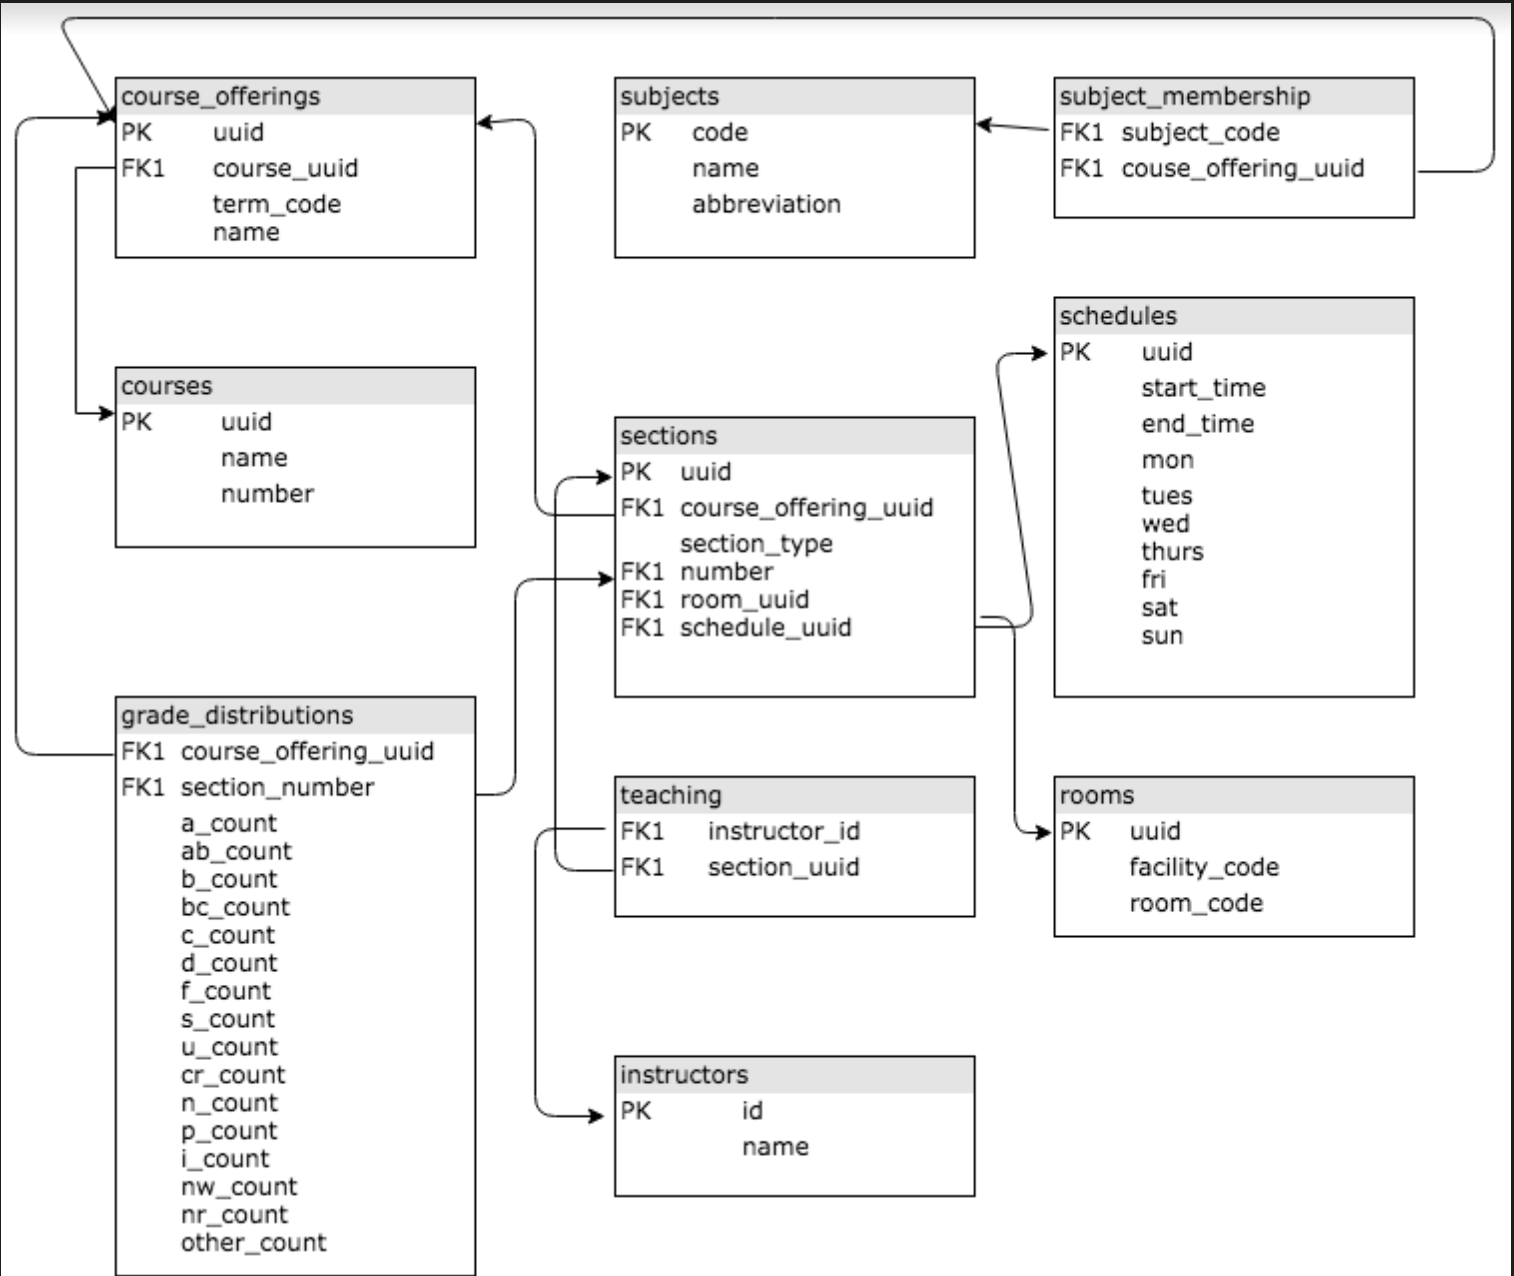


# Hypothesis Test 3

## Question

Is there a statistically significant difference in the mean percentage of A's depending on the number of days a class meets a week?

## Hypotheses

Null Hypothesis: There is no significant difference in the mean percentage of A's if a class meets one day a week or 2-5 days a week. 
($\mu$1 = $\mu$2 = $\mu$3 = $\mu$4 = $\mu$5)

Alternate Hypothesis: There is a significant difference in the mean percentage of A's if a class meets one day a week or 2-5 days a week. 
($\mu$1 != $\mu$2 != $\mu$3 != $\mu$4 != $\mu$5)


## Methodology

We select an alpha value of 0.05.

First, we will perform a one-way F-statistic test first to confirm there is a significance between the five groups.
If there is a significant difference, we will look first at a two-tail, two-sample t-test on each pairing of the days to see if there is a significant difference between two specific days. Finally, if the two sample test does how significance we will perform more testing to see if one day performs better than another day (a one-tailed, two-sample, t-test).

### Import Necessary Libraries

In [1]:
import math
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from simulations import simulate_days_ttests_with_samples

np.random.seed(2019)


## Data Preparation

### Connect to UW-Madison PostgreSQL database

Run code in setup_database.ipynb to create a local version of the database.

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

We are interested in the percentage of A's given in a specific course and section. While there are other grades such as "credit" and "incomplete", these grades are not given a GPA value and we will therefore ignore them and only use A-F grades. We also want to collect the days a course/section meets so we can get the total number of days that a class meets. Finally, we want the section type as we want to make sure that we measure Lecture and Seminar classes as opposed to Independent/Field Studies and Labs/Discussions (which often contribute to a lecture class' grade).


In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.mon
, sched.tues
, sched.wed
, sched.thurs
, sched.fri
, sched.sat
, sched.sun
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]

Create new columns with the total number of students and the number of days a class meets a week.

In [5]:
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])

In [6]:
df['days_a_week'] = sum([df['mon'], df['tues'], df['wed'], df['thurs'], df['fri'], df['sat'], df['sun']])

In [7]:
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,FLD,36ab1e06-94ef-363f-841c-0e923bfbdac7,10,0,0
1,16,2,5,0,0,0,0,True,False,True,False,False,False,False,LAB,3c59e623-7e61-343a-951a-765cb62d3304,4,23,2
2,19,0,1,0,0,0,0,False,False,False,False,True,False,False,LAB,3c59e623-7e61-343a-951a-765cb62d3304,8,20,1
3,12,9,0,1,4,0,1,False,True,False,True,False,False,False,LAB,dd3caaea-05bf-383a-afa4-52297c455208,6,27,2
4,14,0,3,5,1,0,0,False,False,False,True,False,False,False,LAB,dd3caaea-05bf-383a-afa4-52297c455208,7,23,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217399 entries, 0 to 217398
Data columns (total 19 columns):
a_count                 217399 non-null int64
ab_count                217399 non-null int64
b_count                 217399 non-null int64
bc_count                217399 non-null int64
c_count                 217399 non-null int64
d_count                 217399 non-null int64
f_count                 217399 non-null int64
mon                     217399 non-null bool
tues                    217399 non-null bool
wed                     217399 non-null bool
thurs                   217399 non-null bool
fri                     217399 non-null bool
sat                     217399 non-null bool
sun                     217399 non-null bool
section_type            217399 non-null object
course_offering_uuid    217399 non-null object
section_number          217399 non-null int64
total_count             217399 non-null int64
days_a_week             217399 non-null int64
dtypes: bool(7), int

We have grades for 217,399 courses and sections.

In [9]:
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
22931,2,11,13,0,0,0,0,True,True,True,True,True,True,True,FLD,dea21d58-b5bb-331d-9a15-6de8b5fbc240,81,26,7
13923,3,12,9,0,0,0,0,True,True,True,True,True,True,True,FLD,d00c9390-ad72-3c64-8ed1-3195e2690095,81,24,7
176879,7,10,6,0,0,0,0,True,True,True,True,True,True,True,FLD,53abf93f-707e-3cae-afb1-fa0a69c21b4a,82,23,7
176880,1,3,15,5,0,0,0,True,True,True,True,True,True,True,FLD,6aec025e-376b-3119-b32d-8b64abfd5c10,81,24,7
176881,12,2,22,0,0,0,0,True,True,True,True,True,True,True,FLD,24a7419e-285d-3ce7-a3af-f204348bef02,82,36,7


In [10]:
df.sort_values(by='days_a_week', ascending=True).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,FLD,36ab1e06-94ef-363f-841c-0e923bfbdac7,10,0,0
87663,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,519dfcc6-735b-31d7-91d2-123d0a2649d3,68,0,0
87662,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,c5197ef7-c909-3bf3-90a7-f015b1886ac5,68,0,0
87661,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,4b22153d-f320-37d3-9872-36c9b7f16074,65,0,0
87660,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,4b22153d-f320-37d3-9872-36c9b7f16074,79,0,0


We can see that there are several classes that meet zero times a week. We want to drop these. We also see that there are classes that meet 6-7 days a week which are FLD or IND, which are not representative of our problem as these are usually student paced/scheduled. As all these values are no use to our test, we will drop classes that meet 0, 6, or 7 days a week.

In [11]:
df = df[df['days_a_week'] < 6]
df = df[df['days_a_week'] > 0]
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
172460,11,4,1,0,1,0,0,True,True,True,True,True,False,False,LEC,b3e2c544-9ded-35db-a310-0215921cdaba,2,17,5
120941,7,0,0,0,0,0,0,True,True,True,True,True,False,False,FLD,2ee0b726-6e74-3174-bce1-604d0c1905d0,2,7,5
120939,0,0,0,0,0,0,0,True,True,True,True,True,False,False,FLD,83b43a53-48b7-33dd-851d-61e5744155f8,2,0,5
120938,0,0,0,0,0,0,0,True,True,True,True,True,False,False,FLD,83b43a53-48b7-33dd-851d-61e5744155f8,2,0,5
120937,0,0,0,0,0,0,0,True,True,True,True,True,False,False,FLD,83b43a53-48b7-33dd-851d-61e5744155f8,2,0,5


There are some lectures that meet 5 days a week. So we will drop any remaining FLD or IND as well as LAB and DIS for reasons proposed earlier.

In [12]:
df = df[df['section_type'] != 'FLD']
df = df[df['section_type'] != 'IND']
df = df[df['section_type'] != 'LAB']
df = df[df['section_type'] != 'DIS']
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
62126,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,ec8208e9-4ad1-3a81-9992-c9965a46d182,1,0,5
154946,8,4,3,1,0,1,0,True,True,True,True,True,False,False,LEC,1ad947c6-46af-3fc1-a766-9aad6dc9c55c,1,17,5
64099,5,1,1,0,0,0,0,True,True,True,True,True,False,False,LEC,6ab2cbcb-8e7a-3324-9731-0adc22ee2c3d,1,7,5
200824,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,475e07d1-b027-341e-935b-eb606a26ad63,1,0,5
200823,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,9828f334-6d10-307f-8122-8e18ef09d9b2,1,0,5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97256 entries, 10 to 217398
Data columns (total 19 columns):
a_count                 97256 non-null int64
ab_count                97256 non-null int64
b_count                 97256 non-null int64
bc_count                97256 non-null int64
c_count                 97256 non-null int64
d_count                 97256 non-null int64
f_count                 97256 non-null int64
mon                     97256 non-null bool
tues                    97256 non-null bool
wed                     97256 non-null bool
thurs                   97256 non-null bool
fri                     97256 non-null bool
sat                     97256 non-null bool
sun                     97256 non-null bool
section_type            97256 non-null object
course_offering_uuid    97256 non-null object
section_number          97256 non-null int64
total_count             97256 non-null int64
days_a_week             97256 non-null int64
dtypes: bool(7), int64(10), object(2)
m

After dropping these rows we are left with 97,256 courses/sections.

Like with time of day, there may be some classes with zero students. We want to drop these as it is not reflective of our study.

In [14]:
df = df[df['total_count'] != 0]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85084 entries, 39 to 217398
Data columns (total 19 columns):
a_count                 85084 non-null int64
ab_count                85084 non-null int64
b_count                 85084 non-null int64
bc_count                85084 non-null int64
c_count                 85084 non-null int64
d_count                 85084 non-null int64
f_count                 85084 non-null int64
mon                     85084 non-null bool
tues                    85084 non-null bool
wed                     85084 non-null bool
thurs                   85084 non-null bool
fri                     85084 non-null bool
sat                     85084 non-null bool
sun                     85084 non-null bool
section_type            85084 non-null object
course_offering_uuid    85084 non-null object
section_number          85084 non-null int64
total_count             85084 non-null int64
days_a_week             85084 non-null int64
dtypes: bool(7), int64(10), object(2)
m

After dropping classes with 0 students we have 85,084 courses/students.

Next, we create a copy of our data frame.

In [16]:
df2 = df.copy()

Create a new column that represents the percentage of A's in the course/section.

In [17]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85084 entries, 39 to 217398
Data columns (total 20 columns):
a_count                 85084 non-null int64
ab_count                85084 non-null int64
b_count                 85084 non-null int64
bc_count                85084 non-null int64
c_count                 85084 non-null int64
d_count                 85084 non-null int64
f_count                 85084 non-null int64
mon                     85084 non-null bool
tues                    85084 non-null bool
wed                     85084 non-null bool
thurs                   85084 non-null bool
fri                     85084 non-null bool
sat                     85084 non-null bool
sun                     85084 non-null bool
section_type            85084 non-null object
course_offering_uuid    85084 non-null object
section_number          85084 non-null int64
total_count             85084 non-null int64
days_a_week             85084 non-null int64
ratio_of_as             85084 non-null 

We want to ensure that every row is unique (has a unique combination of `course_offering_uuid` and `section_number`) so we will drop duplicates if there are any.

In [19]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71381 entries, 39 to 217398
Data columns (total 20 columns):
a_count                 71381 non-null int64
ab_count                71381 non-null int64
b_count                 71381 non-null int64
bc_count                71381 non-null int64
c_count                 71381 non-null int64
d_count                 71381 non-null int64
f_count                 71381 non-null int64
mon                     71381 non-null bool
tues                    71381 non-null bool
wed                     71381 non-null bool
thurs                   71381 non-null bool
fri                     71381 non-null bool
sat                     71381 non-null bool
sun                     71381 non-null bool
section_type            71381 non-null object
course_offering_uuid    71381 non-null object
section_number          71381 non-null int64
total_count             71381 non-null int64
days_a_week             71381 non-null int64
ratio_of_as             71381 non-null 

Dropping duplicates has brought our number of courses/sections to 71,381.

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


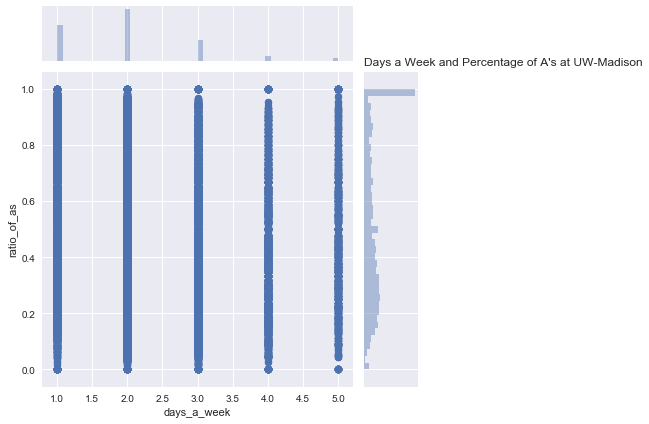

In [20]:
sns.jointplot('days_a_week', 'ratio_of_as',df2)
plt.title("Days a Week and Percentage of A's at UW-Madison", loc='left')
plt.show();

The scatterplot itself does not tell us too much, but if we look at the histograms we can see the most classes meet 2 days a week followed by one day a week. We can also see that a very large majority of classes have very high (almost 1.0) percentage of students that receive an A.

## Modeling/Testing

### One-Way ANOVA

Create new columns for one-hot encoding for days a class meets a week in order to perform a one-way ANOVA test.

In [21]:
dummied_days = pd.get_dummies(df2, columns=['days_a_week'])

In [22]:
dummied_days.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,...,section_type,course_offering_uuid,section_number,total_count,ratio_of_as,days_a_week_1,days_a_week_2,days_a_week_3,days_a_week_4,days_a_week_5
39,2,2,0,2,2,0,0,False,True,False,...,LEC,a1cb7229-b991-39ab-99be-521e1fbd73cb,4,8,0.250000,0,1,0,0,0
40,55,7,4,1,1,2,0,True,False,True,...,LEC,601ea3ef-7a7b-339f-9e3f-463d819305aa,1,70,0.785714,0,1,0,0,0
41,5,2,3,2,0,1,0,False,True,False,...,LEC,fd7a3e03-a30b-3117-b431-e5f27d644f43,31,13,0.384615,0,1,0,0,0
42,1,2,4,3,2,1,0,False,True,False,...,LEC,bbe66764-b560-3fe2-b35a-195eb60e6112,53,13,0.076923,0,1,0,0,0
43,7,4,1,0,1,0,0,True,False,True,...,LEC,bbe66764-b560-3fe2-b35a-195eb60e6112,13,13,0.538462,0,0,1,0,0


In [23]:
formula = 'ratio_of_as~C(days_a_week_1)+C(days_a_week_2)+C(days_a_week_3)+C(days_a_week_4)+C(days_a_week_5)'
lm = ols(formula, dummied_days).fit()
table = sm.stats.anova_lm(lm, type=3)
print(table)

                       df       sum_sq      mean_sq             F  \
C(days_a_week_1)      1.0  1367.433258  1367.433258  20316.415469   
C(days_a_week_2)      1.0    12.173341    12.173341    180.863422   
C(days_a_week_3)      1.0     5.998375     5.998375     89.119875   
C(days_a_week_4)      1.0     3.960900     3.960900     58.848419   
C(days_a_week_5)      1.0     0.118021     0.118021      1.753475   
Residual          71375.0  4804.024064     0.067307           NaN   

                        PR(>F)  
C(days_a_week_1)  0.000000e+00  
C(days_a_week_2)  3.524738e-41  
C(days_a_week_3)  3.823099e-21  
C(days_a_week_4)  1.724462e-14  
C(days_a_week_5)  1.854447e-01  
Residual                   NaN  


Using the Bonferroni correction we adjust our alpha to reflect 5 independent variables (0.05 / 5). Our adjusted alpha is 0.01. Since looking at two-tailed we are looking at `PR(>F)`'s that are less than 0.005

We are comparing to 1 day a week.

The `PR(>F)` values are less than alpha for 2, 3, and 4 days which means we reject the null and there is a difference in the percentage of A's given whether the class meets 2 to 1, 3 to 1, or 4 to 1 days a week. The `PR(>F)` for five is greater than alpha so we fail to reject the null. There is not enough information to say that there is a difference between meeting 1 day a week and 5 days a week.

The most influential of 2, 3, and 4 appears to be 2 days a week as it has the smallest `PR(>F)` value.

### One-Way F-Statistic Test

For further confirmation, we check a one-way F-statistic test on the same data.

First, we narrow down our dataframe to just our dependent and independent variables.

In [24]:
days_and_as = pd.DataFrame({'days_a_week': df2['days_a_week'], 'ratio_of_as': df2['ratio_of_as']})

We then split that dataframe into separate dataframes depending on how many days a week the class meets.

In [25]:
one_day = days_and_as.loc[days_and_as['days_a_week'] == 1, 'ratio_of_as']
two_days = days_and_as.loc[days_and_as['days_a_week'] == 2, 'ratio_of_as']
three_days = days_and_as.loc[days_and_as['days_a_week'] == 3, 'ratio_of_as']
four_days = days_and_as.loc[days_and_as['days_a_week'] == 4, 'ratio_of_as']
five_days = days_and_as.loc[days_and_as['days_a_week'] == 5, 'ratio_of_as']

In [26]:
stats.f_oneway(one_day, two_days, three_days, four_days, five_days)

F_onewayResult(statistic=5161.7029692405, pvalue=0.0)

The test tells us that there is a significant statistical difference in the mean percentage of A's by how many days a week a class meets, but it does not tell us in which pairing.

### Two-Tailed Two-Sample T-Test

As the number of combinations is small (only 10), we will run a two-tailed, two-sample t-test on each pairing to see which pairings of the five have also show statistical significance.

In [27]:
# Generate the pairs of days
days_pairs = []
days = [1, 2, 3, 4, 5]

for days1 in range(4):
    for days2  in range(days1+1,5):
        days_pairs.append((days[days1], days[days2]))

In [28]:
# Conduct t-test on each pair
for days1, days2 in days_pairs: 
    first = days_and_as.loc[days_and_as['days_a_week'] == days1, 'ratio_of_as']
    second = days_and_as.loc[days_and_as['days_a_week'] == days2, 'ratio_of_as']
    print(days1, days2)
    print(stats.ttest_ind(first, second)) 

1 2
Ttest_indResult(statistic=124.06730444574464, pvalue=0.0)
1 3
Ttest_indResult(statistic=114.51292840584208, pvalue=0.0)
1 4
Ttest_indResult(statistic=58.794794931592975, pvalue=0.0)
1 5
Ttest_indResult(statistic=33.41606962852345, pvalue=2.9967139670890396e-239)
2 3
Ttest_indResult(statistic=16.58871547771558, pvalue=1.2847619665452304e-61)
2 4
Ttest_indResult(statistic=4.502073298273151, pvalue=6.751122649942143e-06)
2 5
Ttest_indResult(statistic=-5.960003315452303, pvalue=2.547577395262443e-09)
3 4
Ttest_indResult(statistic=-4.462963079269022, pvalue=8.139153894994173e-06)
3 5
Ttest_indResult(statistic=-12.782980959959106, pvalue=3.2575970151496453e-37)
4 5
Ttest_indResult(statistic=-8.030417363713093, pvalue=1.234496401539194e-15)


Each of these pairings is statistically significant for two-tailed tests as all p-values are less than 0.025 (half of alpha). We will make new hypotheses to test each pairing.

### One-tailed Two-Sample T-Test

We will keep an alpha value of 0.05.

Of the pairings (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5):

Null hypothesis: The class that meets less in a pair does not have a statistically significant difference in mean percentage of A from the class the meets more times a week ($\mu$1 = $\mu$2).

Alternative: The class that meets less in a pair does have a statistically significant positive difference in mean percentage of A from the class the meets more times a week ($\mu$1 > $\mu$2).

#### Get Sample Size

In [29]:
moe = 0.1 # we chose 0.1 as this is a 10% difference in percentage of A's
z = 1.96 # z value for alpha 0.05

one_var = np.var(one_day)
one_n = len(one_day)
two_var = np.var(two_days)
two_n = len(two_days)
three_var = np.var(three_days)
three_n = len(three_days)
four_var = np.var(four_days)
four_n = len(four_days)
five_var = np.var(five_days)
five_n = len(five_days)

num = ((one_n - 1) * one_var + (two_n - 1) * two_var + (three_n - 1) * three_var 
      + (four_n - 1) * four_var + (five_n - 1) * five_var)
den = one_n + two_n + three_n + four_n + five_n - 5
pooled_std = np.sqrt(num/den)

In [30]:
n = 2 * (z * pooled_std / moe)**2
n = math.ceil(n) # we want have to round up because we can't have a decimal of a class
n

52

#### Simulate t-tests with multiple samples

In [31]:
simulate_days_ttests_with_samples(days_pairs, one_day, two_days, three_days, 
                                  four_days, five_days, seed=1, sample_size=n)

1 2
Ttest_indResult(statistic=4.601366805496189, pvalue=1.2109123599943508e-05)
1 3
Ttest_indResult(statistic=7.036601503409251, pvalue=2.326862411119336e-10)
1 4
Ttest_indResult(statistic=5.955744353023777, pvalue=3.709527150347963e-08)
1 5
Ttest_indResult(statistic=5.015832725599275, pvalue=2.2378423625880197e-06)
2 3
Ttest_indResult(statistic=1.7200955700610279, pvalue=0.08844772421791955)
2 4
Ttest_indResult(statistic=1.0497203367253893, pvalue=0.29632750785658435)
2 5
Ttest_indResult(statistic=0.2341568621099465, pvalue=0.8153325590080349)
3 4
Ttest_indResult(statistic=-0.6353549197646433, pvalue=0.5266197738929156)
3 5
Ttest_indResult(statistic=-1.5401877777052646, pvalue=0.12661125634243645)
4 5
Ttest_indResult(statistic=-0.8468501473798759, pvalue=0.3990612099124098)


Using the p-values < 0.05, the pairs where we reject the null and say the first is significantly greater in ratio of A's than the second are (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (3, 5).

For the remaining pairs we cannot reject the null hypothesis. There is not significant evidence that a short number of days per week performs better than more days a week.

In [32]:
simulate_days_ttests_with_samples(days_pairs, one_day, two_days, three_days, 
                                  four_days, five_days, seed=5, sample_size=n)

1 2
Ttest_indResult(statistic=5.796781904283629, pvalue=7.595783706892485e-08)
1 3
Ttest_indResult(statistic=7.011423189158222, pvalue=2.627424269704302e-10)
1 4
Ttest_indResult(statistic=6.364069184615034, pvalue=5.6706234375659905e-09)
1 5
Ttest_indResult(statistic=6.116638075631802, pvalue=1.7806650624618086e-08)
2 3
Ttest_indResult(statistic=0.8110154213069221, pvalue=0.4192451946295368)
2 4
Ttest_indResult(statistic=-0.04685884633226407, pvalue=0.962717351522686)
2 5
Ttest_indResult(statistic=0.051115577679397346, pvalue=0.9593333905817267)
3 4
Ttest_indResult(statistic=-0.9698664917590385, pvalue=0.3344072592187459)
3 5
Ttest_indResult(statistic=-0.8019102550286343, pvalue=0.4244691858478056)
4 5
Ttest_indResult(statistic=0.10720277281473163, pvalue=0.9148386921728305)


Running the tests a second time on difference random samples, we see that (1, 2), (1, 3), (1, 4), (1, 5), (2, 3) show that the less amount of days meeting is significant.

In [33]:
simulate_days_ttests_with_samples(days_pairs, one_day, two_days, three_days, 
                                  four_days, five_days, seed=10, sample_size=n)

1 2
Ttest_indResult(statistic=4.69146043247523, pvalue=8.448042993192004e-06)
1 3
Ttest_indResult(statistic=6.403958847924186, pvalue=4.707473817256847e-09)
1 4
Ttest_indResult(statistic=3.9387733861283256, pvalue=0.0001500327021278231)
1 5
Ttest_indResult(statistic=2.578629397669214, pvalue=0.01134637395918563)
2 3
Ttest_indResult(statistic=1.2560965204641903, pvalue=0.21195042092449778)
2 4
Ttest_indResult(statistic=-0.8933783446232306, pvalue=0.3737576073857346)
2 5
Ttest_indResult(statistic=-2.0050061479287113, pvalue=0.04761185493984483)
3 4
Ttest_indResult(statistic=-2.305546002358218, pvalue=0.023160341458886114)
3 5
Ttest_indResult(statistic=-3.4175509380522313, pvalue=0.0009089567469145939)
4 5
Ttest_indResult(statistic=-1.1953859867413195, pvalue=0.2347080842189573)


A third set of random samples further confirms that meeting one day a week is related to a higher proportion of grades. The other pairs are not necessarily significant over many trials.

In [34]:
simulate_days_ttests_with_samples(days_pairs, one_day, two_days, three_days, 
                                  four_days, five_days, seed=20, sample_size=n)

1 2
Ttest_indResult(statistic=3.3586694655930938, pvalue=0.0011022004102461092)
1 3
Ttest_indResult(statistic=7.12908213039937, pvalue=1.4875997788969586e-10)
1 4
Ttest_indResult(statistic=4.734155139810624, pvalue=7.11304282912862e-06)
1 5
Ttest_indResult(statistic=5.072001416853905, pvalue=1.769288402022262e-06)
2 3
Ttest_indResult(statistic=3.0477591983250814, pvalue=0.002936077734405401)
2 4
Ttest_indResult(statistic=1.1256013613515465, pvalue=0.26297582462419894)
2 5
Ttest_indResult(statistic=1.305122743556083, pvalue=0.194787603268852)
3 4
Ttest_indResult(statistic=-1.9681518075144881, pvalue=0.05176505531921171)
3 5
Ttest_indResult(statistic=-1.925584175425337, pvalue=0.05694102811792804)
4 5
Ttest_indResult(statistic=0.14448098359564995, pvalue=0.8854057627215279)


A fourth test shows that the most significant pairings are with 1 class a week. In which we reject the null, and support the alternative that the one class a week has a greater mean ratio of A's than meeting 2-5 days a week.

## Evaluation 
Having lecture/seminar classes once a week has a significantlly greater mean of percentages of A's than having class 2, 3, 4, or 5 times a week.